# Transfer learning and fine tuning for image classification

## Transfer learning

### Importing the libraries

In [ ]:
import tensorflow as tf
import seaborn as sns
import zipfile
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
tf.__version__

'2.8.2'

### Loading the images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Computer Vision Masterclass/Datasets/homer_bart_2.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

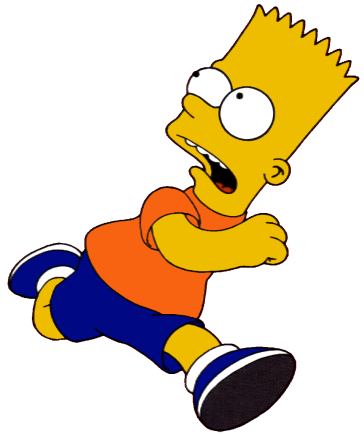

In [ ]:
tf.keras.preprocessing.image.load_img('/content/homer_bart_2/training_set/bart/bart100.bmp')

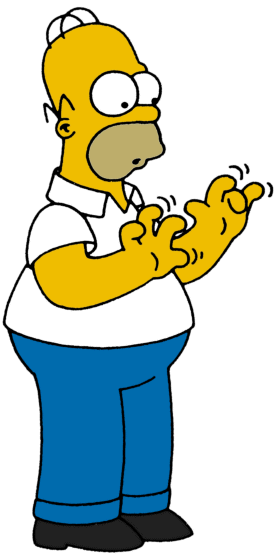

In [ ]:
tf.keras.preprocessing.image.load_img('/content/homer_bart_2/training_set/homer/homer100.bmp')

### Train and test set

In [ ]:
training_generator = ImageDataGenerator(rescale=1./255,
                                        rotation_range=7,
                                        horizontal_flip=True,
                                        zoom_range=0.2)
train_dataset = training_generator.flow_from_directory('/content/homer_bart_2/training_set',
                                                        target_size = (256, 256),
                                                        batch_size = 8,
                                                        class_mode = 'categorical',
                                                        shuffle = True)

Found 215 images belonging to 2 classes.


In [ ]:
train_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
train_dataset.class_indices

{'bart': 0, 'homer': 1}

In [ ]:
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory('/content/homer_bart_2/test_set',
                                                     target_size = (256, 256),
                                                     batch_size = 1,
                                                     class_mode = 'categorical',
                                                     shuffle = False)

Found 54 images belonging to 2 classes.


### Pre-trained network

- ResNet: https://arxiv.org/pdf/1512.03385.pdf
- Documentation: https://keras.io/api/applications/

In [ ]:
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, # inlcude_top = true로 설정을 한다면 image_net 에 있는 1천개의 클래스 분류까지 가져온다.
                                            input_tensor = Input(shape = (256, 256, 3))) # shape는 위 train_set의 shape와 동일하게 설정.

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
len(base_model.layers)

175

In [ ]:
for layer in base_model.layers:
  layer.trainable = False

# 이미 학습된 가중치를 변경하지 않기 위해서 pretrained model.layer.trainable을 False로 둔다.

### Custom dense layer

In [ ]:
base_model.output
# conv_layer, pooling_layer, flatten_layer 는 이미지의 일반적인 특성을 추출하는것과 관련이 있고
# dense layer는 우리가 다루려는 특정 객체의 분류와 관련이 있음.
# 우리가 가져온 모델의 마지막층과 연결을 해야한다.

<KerasTensor: shape=(None, 8, 8, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [ ]:
# Dropout: https://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf
head_model = base_model.output
head_model = GlobalAveragePooling2D()(head_model) # 위의 head_model과 GlobalAveragePooling2D()이 연결됨. 이런식으로 아래에 dense_layer를 계속 연결.
head_model = Dense(units = 1025, activation='relu')(head_model)
head_model = Dropout(rate = 0.2)(head_model)  # 오버핏 방지
head_model = Dense(units = 1025, activation='relu')(head_model)
head_model = Dropout(rate = 0.2)(head_model)
head_model = Dense(2, activation='softmax')(head_model)

### Building and training the neural network

In [ ]:
base_model.input

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
network = Model(inputs = base_model.input, outputs = head_model)

In [ ]:
8 * 8 * 2048
# 일반 flatten을 하였다면 이만큼의 수가 나오게 된다.

131072

In [ ]:
(2048 + 2) / 2
# GlobalAveragePooling2D()을 사용해서 shape를 감소시킨다.
# 1025는 히든레이어의 뉴런 2048에 클래스 갯수 2개(개, 고양이)를 합한 뒤 2로 나누어준 숫자이다.

1025.0

In [ ]:
network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
network.compile(optimizer='Adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = network.fit(train_dataset, epochs=50)

Epoch 1/50
27/27 [==============================] - 16s 115ms/step - loss: 0.9625 - accuracy: 0.5628
Epoch 2/50
27/27 [==============================] - 4s 131ms/step - loss: 0.7651 - accuracy: 0.5721
Epoch 3/50
27/27 [==============================] - 3s 120ms/step - loss: 0.8297 - accuracy: 0.5907
Epoch 4/50
27/27 [==============================] - 3s 122ms/step - loss: 0.6687 - accuracy: 0.6140
Epoch 5/50
27/27 [==============================] - 3s 116ms/step - loss: 0.5931 - accuracy: 0.6977
Epoch 6/50
27/27 [==============================] - 3s 115ms/step - loss: 0.6398 - accuracy: 0.6977
Epoch 7/50
27/27 [==============================] - 3s 115ms/step - loss: 0.5784 - accuracy: 0.7256
Epoch 8/50
27/27 [==============================] - 3s 115ms/step - loss: 0.5783 - accuracy: 0.7116
Epoch 9/50
27/27 [==============================] - 3s 115ms/step - loss: 0.6289 - accuracy: 0.6744
Epoch 10/50
27/27 [==============================] - 3s 115ms/step - loss: 0.5461 - accuracy: 0.748

### Evaluating the neural network

In [ ]:
test_dataset.class_indices

{'bart': 0, 'homer': 1}

In [ ]:
predictions = network.predict(test_dataset)
predictions

array([[9.77159560e-01, 2.28403956e-02],
       [9.43378747e-01, 5.66212125e-02],
       [5.85190654e-01, 4.14809346e-01],
       [9.86132860e-01, 1.38671696e-02],
       [9.84972537e-01, 1.50274755e-02],
       [9.87396538e-01, 1.26034860e-02],
       [8.01279768e-03, 9.91987228e-01],
       [8.56821299e-01, 1.43178686e-01],
       [8.51876855e-01, 1.48123115e-01],
       [9.01303053e-01, 9.86969173e-02],
       [3.61630559e-01, 6.38369441e-01],
       [9.84484434e-01, 1.55155379e-02],
       [9.83249068e-01, 1.67509131e-02],
       [6.73847079e-01, 3.26152861e-01],
       [9.43180323e-01, 5.68197072e-02],
       [9.93710041e-01, 6.29000971e-03],
       [4.22604144e-01, 5.77395856e-01],
       [8.57254028e-01, 1.42745957e-01],
       [9.75728929e-01, 2.42710896e-02],
       [9.84619439e-01, 1.53805632e-02],
       [3.03928465e-01, 6.96071506e-01],
       [9.81638432e-01, 1.83616001e-02],
       [9.99879241e-01, 1.20757264e-04],
       [9.29249048e-01, 7.07509294e-02],
       [9.880458

In [ ]:
predictions = np.argmax(predictions, axis = 1)
predictions

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1])

In [ ]:
test_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
# Approach 1 (all pixels): 0.68
# Approach 2 (features): 0.88
# Approach 3 (CNN): 0.92
# Approach 4 (Transfer learning): 0.79
from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes, predictions)

0.7962962962962963

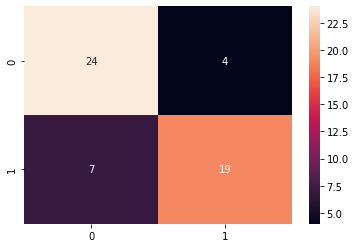

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_dataset.classes, predictions)
sns.heatmap(cm, annot=True);

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       0.77      0.86      0.81        28
           1       0.83      0.73      0.78        26

    accuracy                           0.80        54
   macro avg       0.80      0.79      0.79        54
weighted avg       0.80      0.80      0.80        54



## Fine tuning

### Implementing

In [ ]:
base_model.trainable = True
# fine_funing은 우리가 실제로 분류하고자 하는 이미지와 pretrained_model이 학습한 이미지가 다를경우
# pretrained_model의 마지막에있는 몇개 층의 conv, pooling layer을 dense layer(custom 신경망)와 함께 학습시킬 수 있다.
# learning_rate를 작게 지정하는 것이 필요하다. 따라서 가중치의 변화폭은 작다.
# lr이 크다면 기존에 학습했던 신경망과의 차이가 커서 더 안좋은 결과를 얻을 수 있다.

In [ ]:
for layer in base_model.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fdc3bde3290> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7fdc49629b90> True
<keras.layers.convolutional.Conv2D object at 0x7fdc3a597d10> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fdc3b55ce10> True
<keras.layers.core.activation.Activation object at 0x7fdc3b55cf50> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7fdc3b29c690> True
<keras.layers.pooling.MaxPooling2D object at 0x7fdc3b0674d0> True
<keras.layers.convolutional.Conv2D object at 0x7fdc3b080210> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fdc3b07a550> True
<keras.layers.core.activation.Activation object at 0x7fdc3b011150> True
<keras.layers.convolutional.Conv2D object at 0x7fdc3b011dd0> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fdc3b088ed0> True
<keras.layers.core.activation.Activation object at 0x7fdc3b014410> True
<keras.layer

In [ ]:
len(base_model.layers)

175

In [ ]:
fine_tuning_at = 140

In [ ]:
for layer in base_model.layers[:fine_tuning_at]:
  layer.trainable = False

# 0~139번 layer는 픽스하고 140~175 layer만 True로 줘서 가중치를 변경할 수 있게 한다.
# 여기서 중요한것은 고정을 해제할 때 마지막 conv_ layer

In [ ]:
network.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = network.fit(train_dataset, epochs=50)

Epoch 1/50
27/27 [==============================] - 7s 116ms/step - loss: 3.9699 - accuracy: 0.5628
Epoch 2/50
27/27 [==============================] - 3s 119ms/step - loss: 0.7686 - accuracy: 0.5814
Epoch 3/50
27/27 [==============================] - 3s 119ms/step - loss: 0.7106 - accuracy: 0.5953
Epoch 4/50
27/27 [==============================] - 3s 117ms/step - loss: 0.5569 - accuracy: 0.6279
Epoch 5/50
27/27 [==============================] - 3s 118ms/step - loss: 0.5626 - accuracy: 0.6744
Epoch 6/50
27/27 [==============================] - 3s 119ms/step - loss: 0.5156 - accuracy: 0.7674
Epoch 7/50
27/27 [==============================] - 3s 118ms/step - loss: 0.6478 - accuracy: 0.6419
Epoch 8/50
27/27 [==============================] - 3s 118ms/step - loss: 0.5450 - accuracy: 0.7349
Epoch 9/50
27/27 [==============================] - 3s 116ms/step - loss: 0.4169 - accuracy: 0.7860
Epoch 10/50
27/27 [==============================] - 3s 118ms/step - loss: 0.4310 - accuracy: 0.8093

### Evaluate 

In [ ]:
predictions = network.predict(test_dataset)
predictions

array([[9.99958277e-01, 4.16674447e-05],
       [5.26143849e-01, 4.73856181e-01],
       [3.10974683e-05, 9.99968886e-01],
       [9.99993443e-01, 6.58257522e-06],
       [7.85190344e-01, 2.14809582e-01],
       [7.47523725e-01, 2.52476275e-01],
       [7.52560236e-03, 9.92474377e-01],
       [1.87760927e-02, 9.81223941e-01],
       [8.41658294e-01, 1.58341736e-01],
       [1.13160685e-02, 9.88683879e-01],
       [2.87499715e-04, 9.99712527e-01],
       [6.60483181e-01, 3.39516848e-01],
       [9.99991775e-01, 8.28263182e-06],
       [4.00405086e-04, 9.99599636e-01],
       [3.91387008e-03, 9.96086121e-01],
       [2.21657455e-01, 7.78342485e-01],
       [9.99981523e-01, 1.84533947e-05],
       [6.22899354e-01, 3.77100617e-01],
       [9.99999881e-01, 1.18547014e-07],
       [9.99999642e-01, 3.96187147e-07],
       [7.29254913e-03, 9.92707431e-01],
       [8.13192248e-01, 1.86807722e-01],
       [9.88306582e-01, 1.16934506e-02],
       [6.11496018e-03, 9.93884981e-01],
       [9.955039

In [ ]:
predictions = np.argmax(predictions, axis = 1)
predictions

array([0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
test_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
# Approach 1 (all pixels): 0.68
# Approach 2 (features): 0.88
# Approach 3 (CNN): 0.92
# Approach 4 (Transfer learning): 0.81
# Approach 4 (Fine tuning): 0.81
from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes, predictions)

0.8148148148148148

## Saving and loading the model

In [ ]:
model_json = network.to_json()
with open('network.json','w') as json_file:
  json_file.write(model_json)
# json file을 불러와서 신경망의 구조를 저장한다.

In [ ]:
from keras.models import save_model
network_saved = save_model(network, 'weights.hdf5')
# 가중치를 저장한다.

In [ ]:
with open('network.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model
# 신경망 구조 로드

'{"class_name": "Functional", "config": {"name": "model", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 256, 256, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "name": "input_1", "inbound_nodes": []}, {"class_name": "ZeroPadding2D", "config": {"name": "conv1_pad", "trainable": false, "dtype": "float32", "padding": [[3, 3], [3, 3]], "data_format": "channels_last"}, "name": "conv1_pad", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"class_name": "Conv2D", "config": {"name": "conv1_conv", "trainable": false, "dtype": "float32", "filters": 64, "kernel_size": [7, 7], "strides": [2, 2], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer

In [ ]:
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('weights.hdf5')
# 가중치 로드
network_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
network_loaded.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

## Classifying one single image

In [ ]:
image = cv2.imread('/content/homer_bart_2/test_set/homer/homer15.bmp')

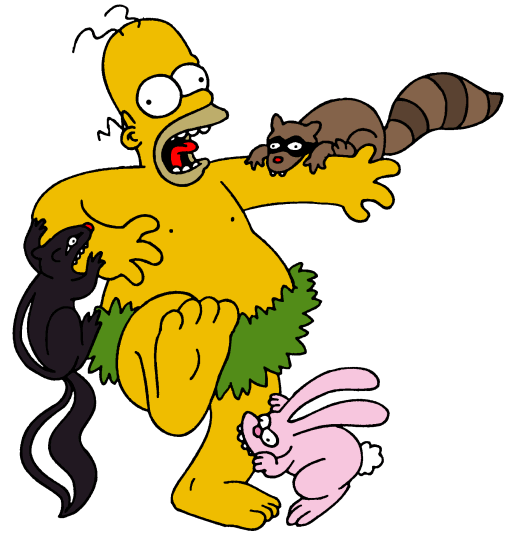

In [ ]:
cv2_imshow(image)

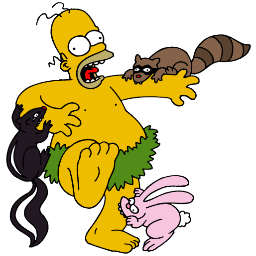

In [ ]:
image = cv2.resize(image, (256, 256))
cv2_imshow(image)

In [ ]:
image

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [ ]:
image = image / 255
image

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]])

In [ ]:
image.shape

(256, 256, 3)

In [ ]:
image = image.reshape(-1, 256, 256, 3)
image.shape
# 1, 256, 256, 3 여기서 1은 신경망에 보낼 이미지의 숫자(amount of images를 의미한다.

(1, 256, 256, 3)

In [ ]:
result = network_loaded(image)
result

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[8.3498372e-04, 9.9916506e-01]], dtype=float32)>

In [ ]:
result = np.argmax(result)
result

1

In [ ]:
test_dataset.class_indices

{'bart': 0, 'homer': 1}

In [ ]:
if result == 0:
  print('Bart')
else:
  print('Homer')

Homer
